In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"

# Layer 2, when feedforward support is noisy

Typically we measure noise tolerance in a layer by adding noise to its feedforward input. We find that the layer is very noise tolerant because of the proximal synapse algorithm. Cells grow synapses to subsets of SDRs in the feedforward input, and they recognize the SDR by checking whether enough of these synapses are active. You can directly control how much noise is required to cause false negatives by increasing this sample size or by lowering the threshold (being careful not to go too low and cause false positives). For most noise levels, the input may have noise, but the calculated list of feedforward supported cells does not. This list has been rescued by the proximal synapses.

In this experiment, I assume that our proximal synapses have failed us. What happens when the list of feedforward supported cells is noisy? Does the rest of the algorithm respond gracefully?

This experiment focuses on false negatives, randomly removing feedforward support from each cell.

In [2]:
from collections import defaultdict
import itertools
import math
import random

import matplotlib.pyplot as plt
import numpy

from htmresearch.frameworks.layers.sensor_placement import greedySensorPositions
from nupic.bindings.math import SparseMatrix, GetNTAReal, Random

## Today's L2 code

Here's the current ColumnPooler, split into two functional components: the part that calculates feedforward support, and the part that consumes the feedforward support and selects the active cells. This is directly analogous to splitting sequence memory into a "Spatial Pooler" and "Temporal Memory".

Splitting it this way allows us to inject noise in the middle.

In [3]:
class FeedforwardPooler(object):
    
    def __init__(self,
                 inputWidth,
                 cellCount=4096,
                 sdrSize=40,
                 synPermProximalInc=0.1,
                 synPermProximalDec=0.001,
                 initialProximalPermanence=0.6,
                 sampleSizeProximal=20,
                 minThresholdProximal=10,
                 connectedPermanenceProximal=0.50,
                 seed=42):
        
        self.inputWidth = inputWidth
        self.cellCount = cellCount
        self.sdrSize = sdrSize
        self.synPermProximalInc = synPermProximalInc
        self.synPermProximalDec = synPermProximalDec
        self.initialProximalPermanence = initialProximalPermanence
        self.connectedPermanenceProximal = connectedPermanenceProximal
        self.sampleSizeProximal = sampleSizeProximal
        self.minThresholdProximal = minThresholdProximal

        self._random = Random(seed)

        self.permanences = SparseMatrix(cellCount, inputWidth)

        
    def learn(self, learningCells, feedforwardInput):
        _learn(self.permanences, self._random,
               sorted(learningCells), sorted(feedforwardInput),
               self.sampleSizeProximal, self.initialProximalPermanence,
               self.synPermProximalInc, self.synPermProximalDec,
               self.connectedPermanenceProximal)
    
    
    def infer(self, feedforwardInput):
        overlaps = _rightVecSumAtNZGtThreshold_sparse(
            self.permanences, sorted(feedforwardInput),
            self.connectedPermanenceProximal)
        feedforwardSupportedCells = numpy.where(overlaps >= self.minThresholdProximal)[0]
        return set(feedforwardSupportedCells)
        


class ActiveCellSelector(object):
    def __init__(self,
                 lateralInputWidths=(),
                 cellCount=4096,
                 sdrSize=40,

                 # Distal
                 synPermDistalInc=0.1,
                 synPermDistalDec=0.001,
                 initialDistalPermanence=0.6,
                 sampleSizeDistal=20,
                 activationThresholdDistal=13,
                 connectedPermanenceDistal=0.50,
                 distalSegmentInhibitionFactor=1.5,

                 seed=42):
        self.cellCount = cellCount
        self.sdrSize = sdrSize
        self.synPermDistalInc = synPermDistalInc
        self.synPermDistalDec = synPermDistalDec
        self.initialDistalPermanence = initialDistalPermanence
        self.connectedPermanenceDistal = connectedPermanenceDistal
        self.sampleSizeDistal = sampleSizeDistal
        self.activationThresholdDistal = activationThresholdDistal
        self.distalSegmentInhibitionFactor = distalSegmentInhibitionFactor

        self.activeCells = ()
        self.supportedActiveCells = ()
        self._random = Random(seed)

        # These sparse matrices will hold the synapses for each segment.
        # Each row represents one segment on a cell, so each cell potentially has
        # 1+len(lateralInputWidths) distal segments.
        self.internalDistalPermanences = SparseMatrix(cellCount, cellCount)
        self.distalPermanences = tuple(SparseMatrix(cellCount, n)
                                       for n in lateralInputWidths)
        
        
    def getLateralOutput(self):
        """
        This allows us to plug other algorithms into existing experiments.
        
        Some algorithms may not want the experiment to use the active cells
        as lateral output.
        """
        return self.activeCells


    def declareObject(self, objectSDR):
        self.reset() # subclasses might need to do extra cleanup
        self.activeCells = sorted(objectSDR)


    def reset(self):
        self.activeCells = ()
        
        
    def learn(self, lateralInputs):
        # When learning, the current active cells are equal to the previous active cells
        prevActiveCells = self.activeCells

        # Internal distal learning
        _learn(self.internalDistalPermanences, self._random,
               self.activeCells, prevActiveCells,
               self.sampleSizeDistal, self.initialDistalPermanence,
               self.synPermDistalInc, self.synPermDistalDec,
               self.connectedPermanenceDistal)

        # External distal learning
        for i, lateralInput in enumerate(lateralInputs):
            _learn(self.distalPermanences[i], self._random,
                   self.activeCells, sorted(lateralInput),
                   self.sampleSizeDistal, self.initialDistalPermanence,
                   self.synPermDistalInc, self.synPermDistalDec,
                   self.connectedPermanenceDistal)
    
    
    def infer(self, feedforwardSupportedCells, lateralInputs):
        prevActiveCells = self.activeCells
        prevSupportedActiveCells = self.supportedActiveCells

        # Calculate lateral support
        numActiveSegmentsByCell = numpy.zeros(self.cellCount, dtype="int")
        overlaps = _rightVecSumAtNZGtThreshold_sparse(
            self.internalDistalPermanences, prevActiveCells,
            self.connectedPermanenceDistal)
        numActiveSegmentsByCell[overlaps >= self.activationThresholdDistal] += 1
        for i, lateralInput in enumerate(lateralInputs):
            overlaps = _rightVecSumAtNZGtThreshold_sparse(
                self.distalPermanences[i], sorted(lateralInput),
                self.connectedPermanenceDistal)
            numActiveSegmentsByCell[overlaps >= self.activationThresholdDistal] += 1

        # Choose from the feedforward supported cells
        minNumActiveCells = self.sdrSize / 2
        chosenCells = self._chooseCells(feedforwardSupportedCells,
                                        minNumActiveCells, numActiveSegmentsByCell)

        # If necessary, choose from previously active cells
        if len(chosenCells) < minNumActiveCells:
            remainingCandidates = [cell for cell in prevActiveCells
                                   if cell not in feedforwardSupportedCells]
            chosenCells.extend(self._chooseCells(remainingCandidates,
                                                 minNumActiveCells - len(chosenCells),
                                                 numActiveSegmentsByCell))

        self.activeCells = sorted(chosenCells)


    def _chooseCells(self, candidates, n, numActiveSegmentsByCell):
        orderedCandidates = sorted(candidates,
                                  key=numActiveSegmentsByCell.__getitem__,
                                  reverse=True)
        activeSegmentCounts = sorted(set(numActiveSegmentsByCell[cell]
                                         for cell in candidates),
                                     reverse=True)
        
        chosenCells = []
        i = 0

        for activeSegmentCount in activeSegmentCounts:
            if len(chosenCells) >= n or i >= len(orderedCandidates):
                break

            if activeSegmentCount == 0:
                chosenCells.extend(orderedCandidates[i:])
                break

            # If one cell has 'distalSegmentInhibitionFactor' * the number of active
            # segments of another cell, the latter cell is inhibited.
            boundary = float(activeSegmentCount) / self.distalSegmentInhibitionFactor

            while (i < len(orderedCandidates) and
                   numActiveSegmentsByCell[orderedCandidates[i]] > boundary):
                chosenCells.append(orderedCandidates[i])
                i += 1

        return chosenCells

        
def _learn(# mutated args
           permanences, rng,

           # activity
           activeCells, activeInput,

           # configuration
           sampleSize, initialPermanence, permanenceIncrement,
           permanenceDecrement, connectedPermanence):
    permanences.incrementNonZerosOnOuter(
        activeCells, activeInput, permanenceIncrement)
    permanences.incrementNonZerosOnRowsExcludingCols(
        activeCells, activeInput, -permanenceDecrement)
    permanences.clipRowsBelowAndAbove(
        activeCells, 0.0, 1.0)
    if sampleSize == -1:
        permanences.setZerosOnOuter(
            activeCells, activeInput, initialPermanence)
    else:
        permanences.increaseRowNonZeroCountsOnOuterTo(
            activeCells, activeInput, sampleSize, initialPermanence, rng)

#
# Functionality that could be added to the C code or bindings
#

def _sampleRange(rng, start, end, step, k):
    """
    Equivalent to:

    random.sample(xrange(start, end, step), k)

    except it uses our random number generator.

    This wouldn't need to create the arange if it were implemented in C.
    """
    array = numpy.empty(k, dtype="uint32")
    rng.sample(numpy.arange(start, end, step, dtype="uint32"), array)
    return array


def _rightVecSumAtNZGtThreshold_sparse(sparseMatrix,
                                       sparseBinaryArray,
                                       threshold):
    """
    Like rightVecSumAtNZGtThreshold, but it supports sparse binary arrays.

    @param sparseBinaryArray (sorted sequence)
    A sorted list of indices.

    Note: this Python implementation doesn't require the list to be sorted, but
    an eventual C implementation would.
    """
    denseArray = numpy.zeros(sparseMatrix.nCols(), dtype=GetNTAReal())
    denseArray[sparseBinaryArray] = 1
    return sparseMatrix.rightVecSumAtNZGtThreshold(denseArray, threshold)

## Experiment code

Touch every point on an object 7 times. In the 7th set of touches, measure how many cells were correctly active and how many are incorrectly active. A layer of cells is considered "correct" if it has at least 30 correctly active cells and no more than 10 incorrectly active cells.

In [4]:
def createRandomObjectDescriptions(numObjects,
                                   numLocationsPerObject,
                                   featurePool=("A", "B", "C")):
    """
    Returns {"Object 1": [(0, "C"), (1, "B"), (2, "C"), ...],
             "Object 2": [(0, "C"), (1, "A"), (2, "B"), ...]}
    """
    return dict(("Object %d" % i,
                 zip(xrange(numLocationsPerObject),
                     [random.choice(featurePool)
                      for _ in xrange(numLocationsPerObject)]))
                for i in xrange(1, numObjects + 1))


def doExperiment(numColumns, sampleSizeDistal, objectDescriptions, faultProbability,
                 numInitialTraversals, selectorConstructor=ActiveCellSelector):

    L4_CELL_COUNT = 8*1024

    # For each column, keep a mapping from feature-location names to their SDRs
    layer4sdr = lambda: set(random.sample(xrange(L4_CELL_COUNT), 40))
    featureLocationSDRs = [defaultdict(layer4sdr) for _ in xrange(numColumns)]

    feedforwardPoolers = [FeedforwardPooler(inputWidth=L4_CELL_COUNT)
                          for _ in xrange(numColumns)]
    activeCellSelectors = [selectorConstructor(lateralInputWidths=[4096]*(numColumns-1),
                                               sampleSizeDistal=sampleSizeDistal)
                          for _ in xrange(numColumns)]

    # Learn the objects
    objectL2Representations = {}
    for objectName, featureLocations in  objectDescriptions.iteritems():
        objectL2Representations[objectName] = []
        for selector in activeCellSelectors:
            objectSDR = set(random.sample(xrange(selector.cellCount), selector.sdrSize))
            objectL2Representations[objectName].append(objectSDR)
            selector.declareObject(objectSDR)

        for featureLocationName in featureLocations:
            for _ in xrange(10):
                allLateralInputs = [s.getLateralOutput() for s in activeCellSelectors]
                for columnNumber in xrange(numColumns):
                    activeCells = objectL2Representations[objectName][columnNumber]
                    feedforwardInput = featureLocationSDRs[columnNumber][featureLocationName]
                    feedforwardPoolers[columnNumber].learn(activeCells, feedforwardInput)

                    lateralInputs = [lateralInput
                                     for i, lateralInput in enumerate(allLateralInputs)
                                     if i != columnNumber]
                    activeCellSelectors[columnNumber].learn(lateralInputs)

    results = []

    # Try to infer the objects
    for objectName, featureLocations in objectDescriptions.iteritems():
        for selector in activeCellSelectors:
            selector.reset()

        sensorPositionsIterator = greedySensorPositions(numColumns, len(featureLocations))

        # Touch each location at least numInitialTouches times, and then touch it
        # once more, testing it.
        numTouchesPerTraversal = len(featureLocations) / float(numColumns)
        numInitialTouches = int(math.ceil(numInitialTraversals * numTouchesPerTraversal))
        numTestTouches = int(math.ceil(1 * numTouchesPerTraversal))
        for touch in xrange(numInitialTouches + numTestTouches):
            sensorPositions = next(sensorPositionsIterator)
            for _ in xrange(3):
                allLateralInputs = [selector.getLateralOutput() for selector in activeCellSelectors]
                for columnNumber in xrange(numColumns):
                    position = sensorPositions[columnNumber]
                    featureLocationName = featureLocations[position]
                    feedforwardInput = featureLocationSDRs[columnNumber][featureLocationName]

                    feedforwardSupportedCells = feedforwardPoolers[columnNumber].infer(feedforwardInput)

                    feedforwardSupportedCells = set(cell for cell in feedforwardSupportedCells
                                                    if random.random() > faultProbability)

                    lateralInputs = [lateralInput
                                     for i, lateralInput in enumerate(allLateralInputs)
                                     if i != columnNumber]
                    
                    activeCellSelectors[columnNumber].infer(feedforwardSupportedCells, lateralInputs)

            if touch >= numInitialTouches:
                for columnNumber, selector in enumerate(activeCellSelectors):
                    activeCells = set(selector.activeCells)
                    inferredCells = objectL2Representations[objectName][columnNumber]

                    results.append((len(activeCells & inferredCells),
                                    len(activeCells - inferredCells)))

    return results

def varyColumns(selectorConstructor=ActiveCellSelector):
    #
    # Run the experiment
    #
    faultProbabilities = [x * 0.01 for x in xrange(0, 101, 5)]
    sampleSizeDistal = 20
    columnCounts = [1, 2, 3, 4]

    results = defaultdict(list)

    for trial in xrange(1):
        print "trial", trial
        objectDescriptions = createRandomObjectDescriptions(10, 10)

        for numColumns in columnCounts:
            print "numColumns", numColumns
            for faultProbability in faultProbabilities:
                r = doExperiment(numColumns, sampleSizeDistal, objectDescriptions,
                                 faultProbability, numInitialTraversals=6,
                                 selectorConstructor=selectorConstructor)
                results[(numColumns, faultProbability)].extend(r)

    #
    # Plot it
    #
    numCorrectActiveThreshold = 30
    numIncorrectActiveThreshold = 10

    plt.figure()
    colors = dict(zip(columnCounts,
                    ('r', 'k', 'g', 'b')))
    markers = dict(zip(columnCounts,
                     ('o', '*', 'D', 'x')))

    for numColumns in columnCounts:
        y = []
        for faultProbability in faultProbabilities:
            trials = results[(numColumns, faultProbability)]
            numPassed = len([True for numCorrect, numIncorrect in trials
                             if numCorrect >= numCorrectActiveThreshold
                             and numIncorrect <= numIncorrectActiveThreshold])
            y.append(numPassed / float(len(trials)))

        plt.plot(faultProbabilities, y,
                 color=colors[numColumns],
                 marker=markers[numColumns])

    lgnd = plt.legend(["%d columns" % numColumns
                       for numColumns in columnCounts],
                      bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.xlabel("Probability of feedforward false negative")
    plt.xticks([0.01 * n for n in xrange(0, 101, 10)])
    plt.ylabel("Success rate")
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.title("Inference with feedforward faults")

    plt.show()
    
    
def varySampleSize(selectorConstructor=ActiveCellSelector):
    #
    # Run the experiment
    #
    faultProbabilities = [x * 0.01 for x in xrange(0, 101, 5)]
    sampleSizes = [13, 20, 30, 40]
    numColumns = 3

    results = defaultdict(list)

    for trial in xrange(1):
        print "trial", trial
        objectDescriptions = createRandomObjectDescriptions(10, 10)

        for sampleSizeDistal in sampleSizes:
            print "sampleSizeDistal", sampleSizeDistal
            for faultProbability in faultProbabilities:
                r = doExperiment(numColumns, sampleSizeDistal, objectDescriptions,
                                 faultProbability, numInitialTraversals=6, 
                                 selectorConstructor=selectorConstructor)
                results[(sampleSizeDistal, faultProbability)].extend(r)

    #
    # Plot it
    #
    numCorrectActiveThreshold = 30
    numIncorrectActiveThreshold = 10

    plt.figure()
    colorList = dict(zip(sampleSizes,
                       ('r', 'k', 'g', 'b')))
    markerList = dict(zip(sampleSizes,
                        ('o', '*', 'D', 'x')))

    for sampleSizeDistal in sampleSizes:
        y = []
        for faultProbability in faultProbabilities:
            trials = results[(sampleSizeDistal, faultProbability)]
            numPassed = len([True for numCorrect, numIncorrect in trials
                             if numCorrect >= numCorrectActiveThreshold
                             and numIncorrect <= numIncorrectActiveThreshold])
            y.append(numPassed / float(len(trials)))

        plt.plot(faultProbabilities, y,
                 color=colorList[sampleSizeDistal],
                 marker=markerList[sampleSizeDistal])

    lgnd = plt.legend(["Distal sample size %d" % sampleSizeDistal
                     for sampleSizeDistal in sampleSizes],
                    bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.xlabel("Probability of feedforward false negative")
    plt.xticks([0.01 * n for n in xrange(0, 101, 10)])
    plt.ylabel("Success rate")
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.title("Inference with feedforward faults")
    plt.show()

How does the noise tolerance vary with column count? (This is with distal sample size of 20)

trial 0
numColumns 1
numColumns 2
numColumns 3
numColumns 4


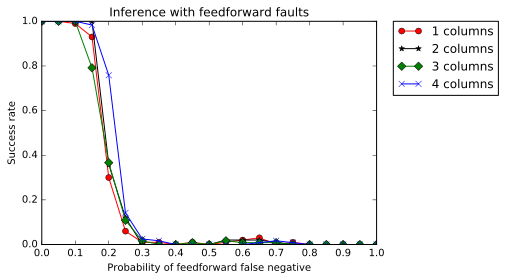

In [5]:
varyColumns()

How does the noise tolerance vary with distal sample size? (This is with 3 columns)

trial 0
sampleSizeDistal 13
sampleSizeDistal 20
sampleSizeDistal 30
sampleSizeDistal 40


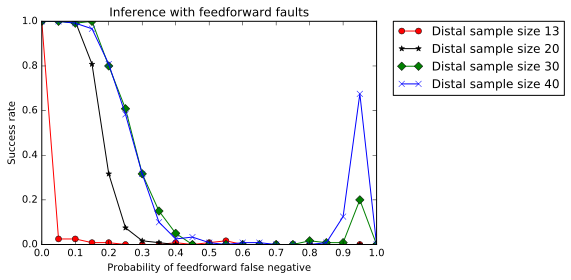

In [6]:
varySampleSize()

## Can we do better?

Here is a modified algorithm. It contains three changes.

### 1. Lateral support keeps cells active, even if the cell doesn't have feedforward support

Previously this was possible, but now we're really embracing it. If Cell A has more lateral support than Cell B, and Cell A was previously active, it will inhibit Cell B -- even if it doesn't have feedforward support.

Before, we prioritized the cells like this:

1. Has feedforward support, 2 active segments
2. Has feedforward support, 1 active segment
3. Has feedforward support, 0 active segments
4. Previously active, 2 active segments
5. Previously active, 1 active segments

With this change, we prioritize the cells like this:

1. Has feedforward support, 2 active segments
2. Previously active, 2 active segments
3. Has feedforward support, 1 active segment
4. Previously active, 1 active segments
5. Has feedforward support, 0 active segments

The principle: Layer 2 is noise tolerant because it tries to keep active cells active, even if their feedforward support drops out. If a cell was previously active and it has lateral support, it is prioritized over cells that have only feedforward support. So if you've inferred Object 1 -- if 40 Object 1 cells are active -- and you look at a feature-location that's on Object 1 and Object 2, you don't have to worry about noise causing some cells to drop out and be replaced by Object 2 cells.

### 2. Cells without feedforward support are less active

This is required by Change 1. Otherwise, the system can get stuck on the wrong object. If 40 Object 2 cells are active, and you look at a feature-location that's only on Object 1, nothing will happen. These previously active cells will stay active without feedforward support, and no Object 1 cells will ever become active. To solve this problem, cells that don't have feedforward support shouldn't provide lateral support. They should just quietly stay active. They'll still inhibit other cells from becoming active, but they won't contribute laterally to anybody's distal segments. So if you drop feedforward support for an entire SDR of cells, they will become inactive after one or two time steps (unless some other cortical column is supporting them).

In other words, cells that don't have feedforward support have lower spike rates. In this implementation, these idly active cells provide no lateral support, but you could also build a system where they simply provide less support than other cells.

### 3. Smoother inhibition

Before, as we activated groups of cells, we would activate each entire group one by one until we reach a threshold (currently 20).

With this change, cells are inhibited proportionally to the number of already-activated cells. The further we are from 40 active cells, the more of the next group that we'll activate. So if we have 10 active cells so far, there's a discrepancy of 30 cells, so we will activate 3/4 of the next group. (Though we'll make sure to activate at least 30, if possible.)

In [7]:
class FaultTolerantActiveCellSelector(ActiveCellSelector):
    def __init__(self, **kwargs):
        super(FaultTolerantActiveCellSelector, self).__init__(**kwargs)
        self.supportedActiveCells = ()


    def reset(self):
        super(FaultTolerantActiveCellSelector, self).reset()
        self.supportedActiveCells = ()
        
        
    def getLateralOutput(self):
        return self.supportedActiveCells
    
    
    def learn(self, lateralInputs):
        super(FaultTolerantActiveCellSelector, self).learn(lateralInputs)
        self.supportedActiveCells = self.activeCells
    
    
    def infer(self, feedforwardSupportedCells, lateralInputs):
        prevActiveCells = self.activeCells
        prevSupportedActiveCells = self.supportedActiveCells

        # Calculate lateral support
        numActiveSegmentsByCell = numpy.zeros(self.cellCount, dtype="int")
        overlaps = _rightVecSumAtNZGtThreshold_sparse(
            self.internalDistalPermanences, prevSupportedActiveCells,
            self.connectedPermanenceDistal)
        numActiveSegmentsByCell[overlaps >= self.activationThresholdDistal] += 1
        for i, lateralInput in enumerate(lateralInputs):
            overlaps = _rightVecSumAtNZGtThreshold_sparse(
                self.distalPermanences[i], sorted(lateralInput),
                self.connectedPermanenceDistal)
            numActiveSegmentsByCell[overlaps >= self.activationThresholdDistal] += 1

        chosenSupportedCells = []
        chosenCells = []
        
        # Arrange the cells into inhibition groups.
        #
        # The first inhibition group is defined by the highest number of active
        # segments. It includes every cell with feedforward support that isn't
        # inhibited by this segment count.
        #
        # The second group is like the first group, but it's the cells that don't
        # have feedforward support.
        #
        # The third inhibition group is defined by the second highest number of
        # active segments. It includes every cell with feedforward support that wasn't
        # part of the first inhibition group and isn't inhibited by this segment count.
        #
        # The fourth inhibition group is like the third, but it's the cells that don't
        # have feedforward support.
        #
        # Etc.
        orderedSupportedCandidates = sorted(
            feedforwardSupportedCells,
            key=numActiveSegmentsByCell.__getitem__,
            reverse=True)

        orderedUnsupportedCandidates = sorted(
            (c for c in prevActiveCells
             if c not in feedforwardSupportedCells
             and numActiveSegmentsByCell[c] > 0),
            key=numActiveSegmentsByCell.__getitem__,
            reverse=True)
        
        activeSegmentCounts = sorted(set(numActiveSegmentsByCell[cell]
                                         for cell in orderedSupportedCandidates) |
                                     set(numActiveSegmentsByCell[cell]
                                         for cell in orderedUnsupportedCandidates),
                                     reverse=True)
        
        chosenSupportedCells = []
        chosenCells = []

        i = 0 # index into orderedSupportedCandidates
        j = 0 # index into orderedUnsupportedCandidates

        for activeSegmentCount in sorted(set(numActiveSegmentsByCell), reverse=True):
            if len(chosenCells) >= self.sdrSize:
                break
                
            if (i >= len(orderedSupportedCandidates) and
                j >= len(orderedUnsupportedCandidates)):
                break

            if activeSegmentCount == 0:
                active = self._selectFromEquallyQualifiedCells(
                    orderedSupportedCandidates[i:], self.sdrSize - len(chosenCells))
                chosenSupportedCells.extend(active)
                chosenCells.extend(active)
                break

            # If one cell has 'distalSegmentInhibitionFactor' * the number of active
            # segments of another cell, the latter cell is inhibited.
            boundary = float(activeSegmentCount) / self.distalSegmentInhibitionFactor

            begin = i
            while (i < len(orderedSupportedCandidates) and
                   numActiveSegmentsByCell[orderedSupportedCandidates[i]] > boundary):
                i += 1
                
            active = self._selectFromEquallyQualifiedCells(
                orderedSupportedCandidates[begin:i], self.sdrSize - len(chosenCells))
            chosenSupportedCells.extend(active)
            chosenCells.extend(active)
                
            if len(chosenCells) >= self.sdrSize:
                break
                
            begin = j
            while (j < len(orderedUnsupportedCandidates) and
                   numActiveSegmentsByCell[orderedUnsupportedCandidates[j]] > boundary):
                j += 1
                
            chosenCells.extend(orderedUnsupportedCandidates[begin:j])


        self.activeCells = sorted(chosenCells)
        self.supportedActiveCells = sorted(chosenSupportedCells)


    def _selectFromEquallyQualifiedCells(self, candidates, discrepancy):
        """
        Select a subset of the candidates. The number to select is determined from two numbers:
        
        - The discrepancy between the current number of active cells and the 'sdrSize'
        - The size of the candidates list
        
        The larger the candidate list, the more cells will be activated.
        The larger the discrepancy, the more cells will be activated.
        
        @param discrepancy (int)
        How many more cells are needed to reach 'sdrSize'
        """
        if len(candidates) > discrepancy:
            n = max(discrepancy,
                    len(candidates)*discrepancy / self.sdrSize)
            return random.sample(candidates, n)
        else:
            return candidates

How does the noise tolerance vary with column count? (This is with distal sample size of 20)

trial 0
numColumns 1
numColumns 2
numColumns 3
numColumns 4


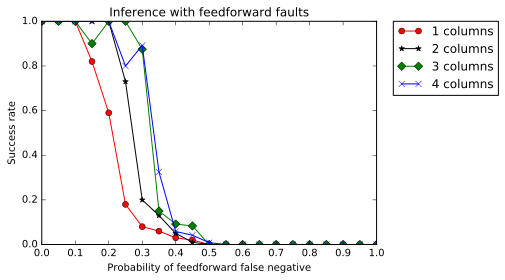

In [8]:
varyColumns(FaultTolerantActiveCellSelector)

How does the noise tolerance vary with distal sample size? (This is with 3 columns)

trial 0
sampleSizeDistal 13
sampleSizeDistal 20
sampleSizeDistal 30
sampleSizeDistal 40


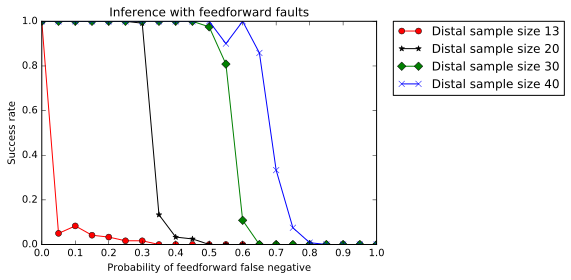

In [9]:
varySampleSize(FaultTolerantActiveCellSelector)

# Conclusion

This algorithm is better at handling false negatives in the feedforward supported cells, especially as you add more distal synapses.

This algorithm requires multiple tiers of "active cells". Some cells can be more active than others. In other words, this algorithm relies on spike rates.